# Homework 8

We will inspect second-order local optimization methods:
- Newton's method
- Quasi-newton method: Davidon-Fletcher-Powell (DFP), Broyden-Fletcher-Goldfarb-Shanno (BFGS), and Limited-memory BFGS (L-BFGS)

In [1]:
#import Pkg; Pkg.add("Optim")
#import Pkg; Pkg.add("ForwardDiff")

using Optim
using Plots
using ForwardDiff
using LinearAlgebra

In [2]:
f_r(x) = (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2
∇f_r(x) = [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]
f_r2(x, y) = (1-x)^2 + 100*(4y - x^2)^2 #quadratic form
H_r(x) = ForwardDiff.hessian(f_r, x)


function rosenplot()
    _f(x, y) = (1-x)^2 + 100*(4y - x^2)^2
    xmin, xmax, ymin, ymax = -3, 2, -2, 2
    x, y = xmin:0.01:xmax, ymin:0.01:ymax
    contour(x, y, _f,
            size=(500, 350),
            levels=[2,10,50,200,500],
            framestyle=:box,
            xlims=(xmin, xmax),
            ylims=(ymin, ymax),
            )
end

function g!(storage, x)
    storage[1] = (2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1))
    storage[2] = (-800*(x[1]^2 - 4x[2]))
end

function h!(storage, x)
    storage[1, 1] = 1200x[1]^2 - 1600x[2] + 2
    storage[1, 2] = -1600x[1]
    storage[2, 1] = -1600x[1]
    storage[2, 2] = 3200
end

h! (generic function with 1 method)

## Newton's Method

In [3]:
function newtons(∇f, H, x, ϵ, k_max=100)
    xs = copy(x)'
    k, Δ = 1, fill(Inf, length(x))
    while norm(Δ) > ϵ && k ≤ k_max
        Δ = H(x) \ ∇f(x)
        x -= Δ
        k += 1
        xs = [xs; (x)']
    end
    return xs
end

newtons (generic function with 2 methods)

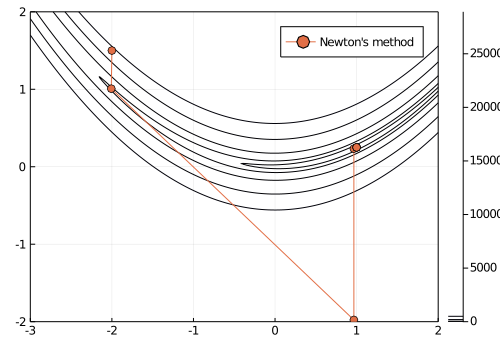

In [4]:
x0 = [-2, 1.5]
k_max = 1000
eps = 1e-8

x_min = newtons(∇f_r, H_r, x0, eps, k_max)

rosenplot()
plot!(x_min[:,1], x_min[:,2], label="Newton's method", m=:o)

In [5]:
println("The true minima: [1, 1/4]; Predicted minima: $(x_min[end, :])")
println("It takes $(size(x_min)[1]-1) steps to find the minima the function.")

print(x_min)

The true minima: [1, 1/4]; Predicted minima: [1.0000000000000062, 0.2500000000000031]
It takes 6 steps to find the minima the function.
[-2.0 1.5; -2.007518796992481 1.0075187969924813; 0.9663757750907855 -1.9775416967959998; 0.9663947738697455 0.23347971465045103; 0.9999999975739949 0.24971767102194428; 0.9999999995530072 0.24999999977650364; 1.0000000000000062 0.2500000000000031]

## Quasi-Newton Method

In [6]:
function line_search(f, ∇, x, d; α=5, β=1e-4, σ=0.1, max_iter=20) 
    y0, g0, y_prev, α_prev = f(x)[1], ∇(x)⋅d, NaN, 0
    αlo, αhi = NaN, NaN
    # bracket phase
    while true
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev) 
            αlo, αhi = α_prev, α
            break
        end
                
        g = ∇(x + α*d)⋅d 
        if abs(g) ≤ -σ*g0
            return α 
        elseif g ≥ 0
            αlo, αhi = α, α_prev
            break
        end
        y_prev, α_prev, α = y, α, 2α
    end

    # zoom phase
    ylo = f(x + αlo*d)[1]
    n = 0
    while n < max_iter
        α = (αlo + αhi)/2
        y = f(x + α*d)[1]
        if y > y0 + β*α*g0 || y ≥ ylo
            αhi = α
        else
            g = ∇(x + α*d)⋅d
            if abs(g) ≤ -σ*g0
                return α
            elseif g*(αhi - αlo) ≥ 0
                αhi = αlo 
            end
            αlo = α 
        end
        n += 1
    end
    return α
end

line_search (generic function with 1 method)

In [54]:
abstract type DescentMethod end

mutable struct DFP <: DescentMethod
    x
    Q
end

function step!(M::DFP, f, ∇f)
    Q, g = M.Q, ∇f(M.x)
    d = -Q*g
    d /= norm(d)
    α = line_search(f, ∇f, M.x, d)
    
    x′ = M.x + α*d
    g′ = ∇f(x′)
    δ = x′ - M.x
    γ = g′ - g
    M.Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
    M.x = x′
end

mutable struct BFGS <: DescentMethod
    x
    Q
end

function step!(M::BFGS, f, ∇f)
    Q, g = M.Q, ∇f(M.x)
    d = -Q*g
    d /= norm(d)
    α = line_search(f, ∇f, M.x, d)
    #M.x +=  α*d
            
    x′ = M.x + α*d
    g′ = ∇f(x′)
    δ = x′ - M.x
    γ = g′ - g
    M.Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
    M.x = x′
end

step! (generic function with 4 methods)

In [55]:
function optimize(M, f, ∇f; f_tol=1e-10, g_tol=1e-2, max_iter=1000, method="DFP")
    xs = copy(M.x)'
    
    for i in 1:max_iter
        x_prev = M.x
        if method == "DFP"
            step!(M::DFP, f, ∇f)
        elseif method == "BFGS"
            step!(M::BFGS, f, ∇f)
        elseif method == "LBFGS"
            step!(M::L_BFGS, f, ∇f)
        end
        xs = [xs; (M.x)']
        
        if abs(f(M.x)[1]-f(x_prev)[1]) < f_tol
            println("Terminate due to function value tolerance")
            break
        elseif norm(∇f(M.x)) < g_tol
            println("Terminate due to gradient tolerance")
            break
        end
    end
    return xs
end

optimize (generic function with 1 method)

Terminate due to function value tolerance
Terminate due to function value tolerance


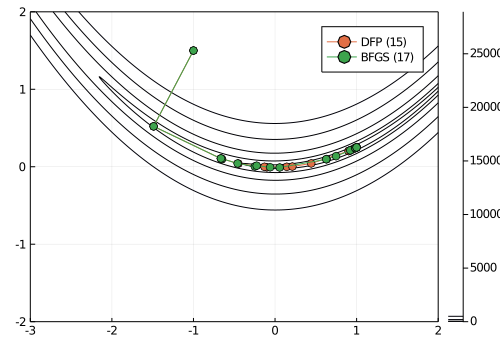

In [56]:
x0 = [-1.0, 1.5]
N_iter, f_tol, g_tol = 1000, 1e-5, 1e-4

M = DFP(x0, Matrix(1.0I, length(x0), length(x0)))
xs_DFP = optimize(M, f_r, ∇f_r, max_iter=N_iter, f_tol=f_tol, g_tol=g_tol)

M = BFGS(x0, Matrix(1.0I, length(x0), length(x0)))
xs_BFGS = optimize(M, f_r, ∇f_r, max_iter=N_iter, f_tol=f_tol, g_tol=g_tol, method="BFGS")

rosenplot()
plot!(xs_DFP[:,1], xs_DFP[:,2], m=:o, label="DFP ($(size(xs_DFP)[1]-1))")
plot!(xs_BFGS[:,1], xs_BFGS[:,2], m=:o, label="BFGS ($(size(xs_BFGS)[1]-1))")

## LBFGS Method

In [43]:
mutable struct L_BFGS <: DescentMethod
    x
    m
    δs
    γs
    qs
end

function step!(M::L_BFGS, f, ∇f)
    δs, γs, qs, g = M.δs, M.γs, M.qs, ∇f(M.x)
    m = length(δs)
    
    if m > 0
        q = g
        for i ∈ m:-1:1
            qs[i] = copy(q)
            q -= (δs[i]⋅q)/(γs[i]⋅δs[i])*γs[i]
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m])
        for i in 1 : m
            z += δs[i]*(δs[i]⋅qs[i] - γs[i]⋅z)/(γs[i]⋅δs[i])
        end
        d = -z
    else
        d = -g
    end
        
    d /= norm(d)
    α = line_search(f, ∇f, M.x, d)
    M.x += α*d
    g′ = ∇f(M.x)
    
    push!(δs, α*d); push!(γs, g′ - g)
    push!(qs, zeros(length(M.x)))
    
    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs)
    end
end

step! (generic function with 4 methods)

Terminate due to function value tolerance


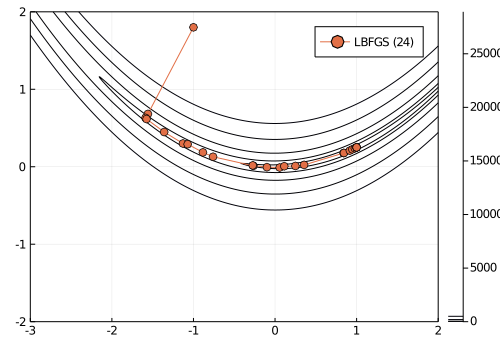

In [45]:
x0 = [-1.0, 1.8]
N_iter, f_tol, g_tol = 1000, 1e-6, 1e-4

M = L_BFGS(x0, 2, [], [], [])
xs_LBFGS = optimize(M, f_r, ∇f_r, max_iter=N_iter, f_tol=f_tol, g_tol=g_tol, 
                    method="LBFGS")

rosenplot()
plot!(xs_LBFGS[:,1], xs_LBFGS[:,2], m=:o, label="LBFGS ($(size(xs_LBFGS)[1]-1))")

In [59]:
println("The true minima: [1, 1/4]")
println("DFP: $(xs_DFP[end,:])")
println("BFGS: $(xs_BFGS[end,:])")
println("LBFGS: $(xs_LBFGS[end,:])")

The true minima: [1, 1/4]
DFP: [0.9998041555215603, 0.24989357690054534]
BFGS: [0.9996527621923099, 0.24982212978560325]
LBFGS: [0.9999778908996406, 0.24998923169852005]


## Conclusion

In term of overall accuracy, it seems like the BFGS and LBFGS performs better than DFP method. Although LBFGS takes 7 more iterations to find the more accurate minima, LBFGS performs better in term of memory efficiency and accuracy.